<a href="https://colab.research.google.com/github/harshith7823/CS760-Project/blob/main/part-1/Death%20prediction/Formula%20generated%20death%20col/experiments_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso, ElasticNetCV,RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt

In [3]:
def fill_death_col(clinical_data):
  
  male_obese = (clinical_data['Sex'] == 1) & (clinical_data['BMI'] > 30)
  female_obese = (clinical_data['Sex'] == -1) & (clinical_data['BMI'] > 30)
  male_underweight = (clinical_data['Sex'] == 1) & (clinical_data['BMI'] < 18.5)
  female_underweight = (clinical_data['Sex'] == -1) & (clinical_data['BMI'] < 18.5)
  clinical_data['BMI_reduction_factor'] = 0
  clinical_data.loc[male_obese, 'BMI_reduction_factor'] = 4.2
  clinical_data.loc[female_obese, 'BMI_reduction_factor'] = 3.5
  clinical_data.loc[male_underweight, 'BMI_reduction_factor'] = 4.3
  clinical_data.loc[female_underweight, 'BMI_reduction_factor'] = 4.5

  clinical_data['Tobacco_reduction_factor'] = np.where(clinical_data['Tobacco']==1,10,0)

  
  #Leave na on rows with no death data, fill the rest with age*365+death days 
  # clinical_data['Age_at_death'] = np.where(clinical_data['DEATH [d from CT]'].isna(), np.nan, clinical_data['Age at CT']*365 + clinical_data['DEATH [d from CT]'])
  clinical_data['Age_at_death'] = np.where(clinical_data['DEATH [d from CT]'].isna(), np.nan, clinical_data['Age at CT'] + clinical_data['DEATH [d from CT]']/365)
  clinical_data['generated_age_at_death'] = np.where(clinical_data['DEATH [d from CT]'].isna(), 1, -1)
  # fill death with avg lifespan - alpha(reduction for tobacco) - beta(reduction for bmi)
  corr_bmi_death = clinical_data['BMI'].corr(clinical_data['Age_at_death'])
  corr_tobacco_death = clinical_data['Tobacco'].corr(clinical_data['Age_at_death'])

  # print(corr_bmi_death)
  # print(corr_tobacco_death)

  #normalize
  alpha = corr_bmi_death/(corr_bmi_death+corr_tobacco_death)
  beta = corr_tobacco_death/(corr_bmi_death+corr_tobacco_death)

  # print(alpha)
  # print(beta)
  
  avg_lifespan_male=76.3  
  avg_lifespan_female=81.2

  clinical_data['avg_life'] = np.where(clinical_data['Sex']==1, avg_lifespan_male, avg_lifespan_female)
  clinical_data['avg_life'] = clinical_data['avg_life'] - alpha*(clinical_data['BMI_reduction_factor'])-beta*(clinical_data['Tobacco_reduction_factor'])
  clinical_data['DEATH [d from CT]'].fillna((clinical_data['avg_life']-clinical_data['Age at CT'])*365, inplace=True)
  clinical_data['Age_at_death'].fillna(clinical_data['Age at CT'] + clinical_data['DEATH [d from CT]']/365, inplace=True)
  
  return clinical_data


In [4]:
def preprocess_clinical_data(oppScrData, mean=True):
    clinical_data = oppScrData.filter(['Record ID','Clinical F/U interval  [d from CT]','BMI','BMI >30', 'Sex', 'Tobacco', 'Met Sx', 'FRAX 10y Fx Prob (Orange-w/ DXA)',
                                'FRAX 10y Hip Fx Prob (Orange-w/ DXA)','FRS 10-year risk (%)','Age at CT', 'DEATH [d from CT]' ], axis=1)
    # Replace all _,X,blanks with nan
    clinical_data = clinical_data.replace(r'_', np.nan, regex=True)
    clinical_data = clinical_data.replace(r'X', np.nan, regex=True)
    clinical_data = clinical_data.replace(r'^\s*$', np.nan, regex=True)

    # Fill na in bmi column with mean
    clinical_data['BMI'].fillna(value=clinical_data['BMI'].mean(skipna=True), inplace=True)
    
    # Fill na in bmi>30 column based on bmi col
    clinical_data.loc[clinical_data.BMI>30, 'BMI >30'] = 1
    clinical_data.loc[clinical_data.BMI<=30, 'BMI >30'] = -1
    
    clinical_data['Sex'] = np.where(clinical_data['Sex']=='Male',1,-1)
    clinical_data['Met Sx'] = np.where(clinical_data['Met Sx']=='Y',1,-1) 

    # Treat no data in tobacco as no tobacco usage 
    clinical_data['Tobacco'] = np.where(clinical_data['Tobacco']=='Yes',1,-1) 
  
    clinical_data['FRS 10-year risk (%)'] = clinical_data['FRS 10-year risk (%)'].replace("<1", 0.01, regex=True)
    clinical_data['FRS 10-year risk (%)'] = clinical_data['FRS 10-year risk (%)'].replace(">30", 0.30, regex=True)
    clinical_data['FRS 10-year risk (%)'] =  clinical_data['FRS 10-year risk (%)'] * 100
   
    cols_to_be_filled = ['FRAX 10y Fx Prob (Orange-w/ DXA)','FRAX 10y Hip Fx Prob (Orange-w/ DXA)','FRS 10-year risk (%)']
    for c in cols_to_be_filled:
      if mean:  
        clinical_data[c].fillna(value=clinical_data[c].mean(skipna=True), inplace=True)
      else :
        clinical_data[c].fillna(value=clinical_data[c].median(skipna=True), inplace=True)

    # clinical_data['Age_at_death'] = np.where(clinical_data['DEATH [d from CT]'].isna(), np.nan, (clinical_data['Age at CT']*365 + clinical_data['DEATH [d from CT]'])/365)
    clinical_data = fill_death_col(clinical_data)
    return [clinical_data, np.array(clinical_data, dtype=np.float32)]

In [5]:
def clean_ct_data(oppScrData):
    # Delete rows with empty values
    ct_data= oppScrData[["L1_HU_BMD", "TAT Area (cm2)", 'Total Body                Area EA (cm2)',
       'VAT Area (cm2)', 'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Liver HU    (Median)']]
    ct_data['Liver HU    (Median)'].replace(' ', np.nan, inplace=True)
    ct_data.dropna(axis = 0, how ='any', thresh = None, subset = None, inplace=True)
    return [ct_data, np.array(ct_data, dtype=np.float32)]

In [6]:
oppScrData = pd.read_excel (r'sample_data/OppScrData.xlsx') 

In [ ]:
clinical_data, clinical_data_np = preprocess_clinical_data(oppScrData)
ct_data, ct_data_np = clean_ct_data(oppScrData)

In [26]:
ct_data['Age_at_death'] = clinical_data['Age_at_death']
ct_data['generated_age_at_death'] = clinical_data['generated_age_at_death']

print(ct_data.columns)

Index(['L1_HU_BMD', 'TAT Area (cm2)',
       'Total Body                Area EA (cm2)', 'VAT Area (cm2)',
       'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Liver HU    (Median)', 'Age_at_death', 'generated_age_at_death'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
print(ct_data['Age_at_death'].isnull().sum())
print(ct_data.shape)

0
(8878, 13)


In [28]:
print((ct_data['generated_age_at_death']==1).sum())

8385


In [29]:
def plot_results(y_pred, y_test, z=15):
  plt.figure()
  y_test_sub, y_pred_sub = y_test, y_pred
  if len(y_test)>200:
    y_test_sub, y_pred_sub = y_test[::z], y_pred[::z]
    
  x = [i+1 for i in range(len(y_test_sub))]
  plt.plot((x,x),([i for i in y_pred_sub], [j for j in y_test_sub]),c='green',markevery=5,)
  plt.scatter(x, y_pred_sub, label="predicted age at death")
  plt.scatter(x, y_test_sub, label="actual age at death")
  plt.xlabel("Patient Record")
  plt.ylabel("Years")
  plt.legend()
  plt.show()

In [30]:
def print_error(y_test, y_pred):
  print(f'MAE = {mean_absolute_error(y_pred, y_test)}')
  print(f'MAPE = {mean_absolute_percentage_error(y_pred, y_test)}')
  print(f'RMSE = {mean_squared_error(y_pred, y_test)**0.5}')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Index(['L1_HU_BMD', 'TAT Area (cm2)',
       'Total Body                Area EA (cm2)', 'VAT Area (cm2)',
       'SAT Area (cm2)', 'VAT/SAT     Ratio', 'Muscle HU',
       ' Muscle Area (cm2)', 'L3 SMI (cm2/m2)', 'AoCa        Agatston',
       'Liver HU    (Median)', 'generated_age_at_death'],
      dtype='object')
SVR
MAE = 10.495701583871877
MAPE = 0.13665471547608163
RMSE = 12.550700721331154


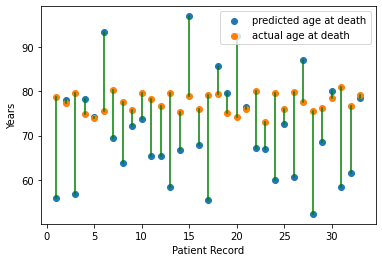

Lasso
MAE = 10.64792944052342
MAPE = 0.13742397983786736
RMSE = 12.744478439205494


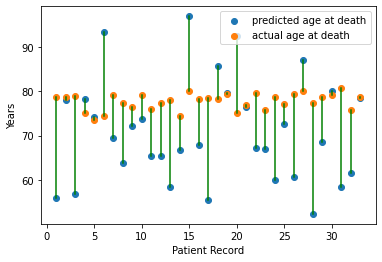

Elastic
MAE = 10.580849199630284
MAPE = 0.1368949117090909
RMSE = 12.71506732305068


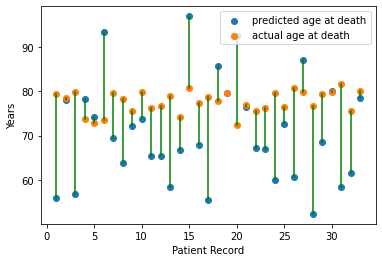

Decision Tree Regressor
MAE = 10.72333601638216
MAPE = 0.1393200844553963
RMSE = 12.843592506767706


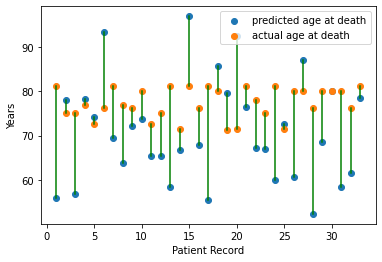

Ridge with CV
MAE = 10.574985479564264
MAPE = 0.13684189884000345
RMSE = 12.709746755482643


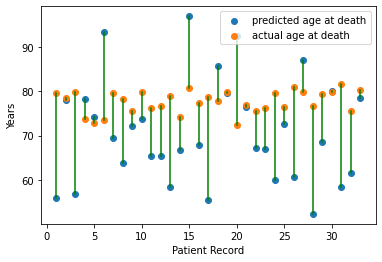

KNNRegressor
MAE = 10.575204824776572
MAPE = 0.13698291164161142
RMSE = 12.707149243364913


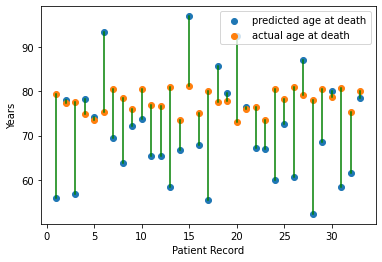

In [31]:
### train on generated data (8.5k) test on ~500
def test_on_actual_with_model(X_train, y_train, X_test, y_test, model):
  regr = make_pipeline(StandardScaler(), model)
  regr.fit(X_train, y_train)
  y_pred = regr.predict(X_test)
  print_error(y_test, y_pred)  
  plot_results(y_test, y_pred)

def train_on_generated_test_on_actual():
  training_data = ct_data.loc[ct_data['generated_age_at_death']==1]
  y_train = np.array(training_data['Age_at_death'])
  training_data= training_data.drop(columns=['Age_at_death'])
  X_train = np.array(training_data)

  testing_data = ct_data.loc[ct_data['generated_age_at_death']==-1]
  y_test = np.array(testing_data['Age_at_death'])
  testing_data.drop(columns=['Age_at_death'], inplace=True)
  X_test = np.array(testing_data)

  print(training_data.columns)

  print('SVR')
  test_on_actual_with_model(X_train, y_train, X_test, y_test, SVR(C=300, epsilon=0.02))

  print('Lasso')
  test_on_actual_with_model(X_train, y_train, X_test, y_test, Lasso(alpha=0.5))

  print('Elastic')
  test_on_actual_with_model(X_train, y_train, X_test, y_test, ElasticNetCV(random_state=0))

  print('Decision Tree Regressor')
  test_on_actual_with_model(X_train, y_train, X_test, y_test, DecisionTreeRegressor(criterion="absolute_error"))

  print('Ridge with CV')
  test_on_actual_with_model(X_train, y_train, X_test, y_test, RidgeCV())

  print("KNNRegressor")
  test_on_actual_with_model(X_train, y_train, X_test, y_test, KNeighborsRegressor())

train_on_generated_test_on_actual()